# To-Do
- Join data tables
 - Set time intervals to 5 minutes
- Feature engineering
 - Weekday/Holiday from date
 - day time - morning, afternoon, night
 - rush hour
- Data Augmentation
 - Enhance weather data by looking up the dates on the web in the city


**Model Building**
- Cluster common routes
- Build a model to predict traffic rating


## Data Set Description
The dataset is composed by two tables. The first table **tracks** presents general 
attributes and each instance has one trajectory that is represented by the table  
**trackspoints**. 

### Tracks Data Table - a list of trajectories  
- id_android - it represents the device used to capture the instance;  
- speed - it represents the average speed (Km/H)  
- time - it represents the time in hours
- distance - it represent the total distance (Km)  
- rating - it is an evaluation parameter. Evaluation the traffic is a way to verify the volunteers 
  perception about the traffic during the travel, in other words,  
  if volunteers move to some place and face traffic jam, maybe they will    evaluate 'bad'. (3-good, 2-normal, 1-bad).  
- rating_bus - it is other evaluation parameter. (1 - The amount of people inside the bus is little, 2 - The bus is not crowded, 3- The bus is crowded.  
- rating_weather - it is another evaluation parameter. ( 2- sunny, 1- raining).  
- car_or_bus - (1 - car, 2-bus)  
- linha - information about the bus that does the pathway  

### Trackspoints Data Table -  localization points of each trajectory  
- id: unique key to identify each point  
- latitude: latitude from where the point is  
- longitude: longitude from where the point is  
- track_id: identify the trajectory which the point belong  
- time: datetime when the point was collected (GMT-3) 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import datetime as dt
#Visualisation Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import seaborn as sns
from data.make_data import DataSet

In [2]:
print("Start reading data:")
parentdir = os.path.dirname(os.getcwd())
datadir = os.path.join(parentdir, "data", "preprocessed")
dataset = DataSet(datadir,file_ending=".csv")
tracks, trackspoints = dataset.get_data()
trackspoints = dataset._preprocess_trackspoint_data(trackspoints)

Start reading data:


Tracks data set

In [3]:
print("Number of data records: ", len(tracks))

tracks.head()

Number of data records:  129


,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
0,1,0,19.210586,8.27,2.652,3,0,0,no_answer,1
1,2,0,30.848229,10.22,5.290,3,0,0,no_answer,1
2,3,1,13.560101,3.90,0.918,3,0,0,no_answer,0
3,4,1,19.766679,27.18,7.700,3,0,0,no_answer,0
4,8,0,25.807401,1.73,3.995,2,0,0,no_answer,1


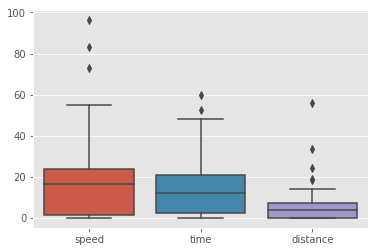

In [16]:
sns.boxplot(data=tracks[['speed','time','distance']]);

Trackspoints data set

In [4]:
print("Number of data records: ", len(trackspoints))
trackspoints.head()

Number of data records:  14206


,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53


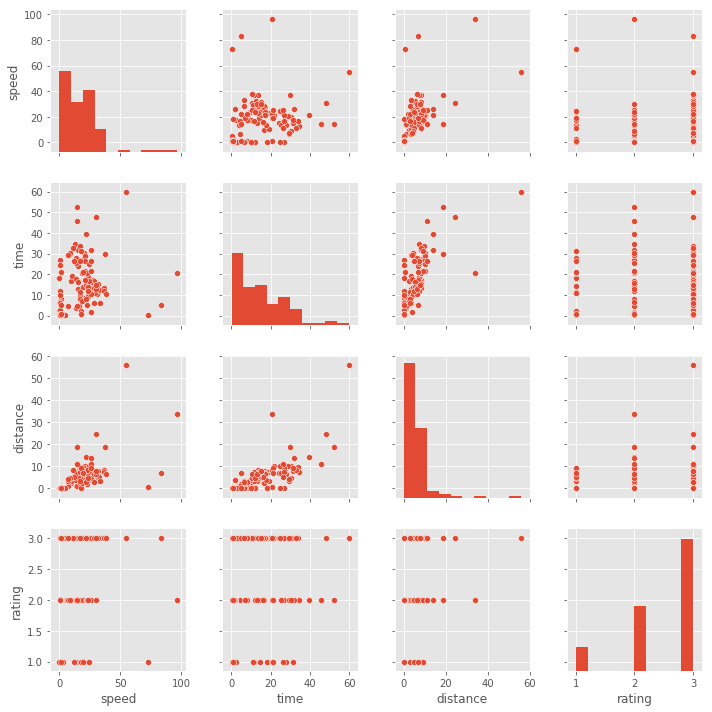

In [5]:
tracks_cor = tracks[['speed','time','distance','rating']]

sns.pairplot(tracks_cor)
plt.tight_layout()
plt.show();

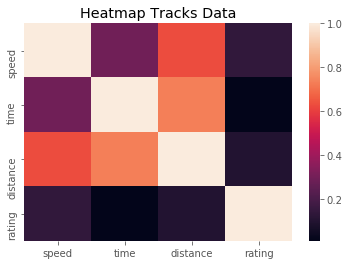

In [21]:
# Calculate correlations
corr = tracks[['speed','time','distance','rating']].corr()
# Heatmap
heatmap = sns.heatmap(corr);
heatmap.set_title("Heatmap Tracks Data");

**Observe the outliers:**

Outliers for speed > 50 $\frac{km}{h}$

In [6]:
tracks[tracks["speed"]>50]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
31,51,2,72.926755,0.37,0.661,1,0,0,no_answer,0
33,55,1,83.328135,4.98,6.976,3,0,0,no_answer,1
34,58,6,96.206029,20.68,33.739,2,0,0,no_answer,0


Outliers for time > 40 minutes

In [7]:
tracks[tracks["time"]>40]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
83,37962,12,14.712053,52.42,18.819,2,0,0,carro,1
98,38002,12,30.397045,47.93,24.461,3,0,0,carro,1
104,38017,16,14.630896,45.80,11.218,2,0,0,carro,1


Outliers for distance > 20 km

In [8]:
tracks[tracks["distance"]>20]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
34,58,6,96.206029,20.68,33.739,2,0,0,no_answer,0
98,38002,12,30.397045,47.93,24.461,3,0,0,carro,1


In [33]:
print("Number tracks with rating 1: ",len(tracks[tracks["rating"]==1]))
print("Number tracks with rating 2: ",len(tracks[tracks["rating"]==2]))
print("Number tracks with rating 3: ",len(tracks[tracks["rating"]==3]))


Number tracks with rating 1  14
Number tracks with rating 2  38
Number tracks with rating 3  77


----
## Model Building

**Linear regression model for predicting traffic rating**

In [70]:
# Normalize values and train test split

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
tracks_scaled = StandardScaler().fit_transform(tracks[['speed','time','distance']])
tracks_scaled_df = pd.DataFrame(tracks_scaled, columns=['speed','time','distance'])
X_train, X_test, y_train, y_test = train_test_split(tracks_scaled_df[['speed','time','distance']], tracks["rating"], test_size=0.20, random_state=1)


In [57]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data=cm, columns=[1,2,3], index=[1,2,3])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    return cm

In [83]:
from sklearn.linear_model import LogisticRegression

# Multiclass prediction of rating 1,2,3
logistic_regression = LogisticRegression(multi_class="multinomial",solver="newton-cg")
logistic_regression.fit(X_train,y_train)

# Make predictions using the testing set
rating_predictions = logistic_regression.predict(X_test)

# The coefficients
print('Coefficients: \n', logistic_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, rating_predictions))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rating_predictions))
print("Prediction: ",[i for i in rating_predictions])
print("True label: ", [i for i in y_test])
error_rate = (rating_predictions != y_test).mean()
print('error rate: %.2f' % error_rate)
cm = confusion_matrix(y_test,rating_predictions)
print("\nConfusion Matrix:")
cm

Coefficients: 
 [[-0.26521393  0.22072469 -0.2654677 ]
 [-0.33425641 -0.18512633  0.37063828]
 [ 0.59947034 -0.03559836 -0.10517058]]
Mean squared error: 1.04
Variance score: -0.70
Prediction:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
True label:  [2, 2, 3, 3, 3, 3, 3, 2, 1, 2, 3, 1, 2, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2, 3, 3, 3]
error rate: 0.46

Confusion Matrix:


Predicted label,1,2,3
True label,,,
1,0,0,5
2,0,0,7
3,0,0,14


Pretty bad prediction. all 3